In [37]:
import pandas as pd
import warnings
from lifelines import CoxPHFitter, CoxTimeVaryingFitter
import re
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
warnings.filterwarnings("ignore")

In [38]:
df = pd.read_csv('../data/base_modelis_pass_det.csv',sep = ';')

In [39]:
df['date_entree_defaut'] = pd.to_datetime(df['date_entree_defaut'], format='%d/%m/%y')
df['date_sortie_defaut'] = pd.to_datetime(df['date_sortie_defaut'], format='%d/%m/%y', errors='coerce')
df['arrete'] = pd.to_datetime(df['arrete'], format='%d/%m/%y')
df['DT_MEP_OPE'] = pd.to_datetime(df['DT_MEP_OPE'], format='%d%b%Y:%H:%M:%S.%f')
df['dt_arr_last_enc_ope'] = pd.to_datetime(df['dt_arr_last_enc_ope'], errors='coerce')
df['dt_arr_1st_enc_ope'] = pd.to_datetime(df['dt_arr_1st_enc_ope'], errors='coerce')
df['dtHJD_prov'] = pd.to_datetime(df['dtHJD_prov'], errors='coerce')
df['dtHJD_def'] = pd.to_datetime(df['dtHJD_def'], errors='coerce')

In [40]:
for column in df.columns :
    if df[column].isna().sum()/df.shape[0] > 0.5 : 
        df.drop(columns = [column], inplace = True)

In [41]:
df.drop(columns = ["CD_POST_BIEN_PFI"], inplace = True)

In [42]:
cols_numeriques = df.select_dtypes(include=['float64', 'int64']).columns.to_list()
cols_categorielles = df.select_dtypes(include=['object']).columns.to_list()
cols_categorielles.remove("cd_op")

for col in cols_numeriques:
    df[col].fillna(df[col].mean(), inplace=True)

for col in cols_categorielles:
    df[col].fillna(df[col].mode()[0], inplace=True)

In [43]:
df_validation = df[df['arrete']>"2020-12-30"]
df_train = df[df['arrete']<"2020-12-30"]
df_train = df_train.reset_index()

In [44]:
liste_var = ['fam_ENQ','solution','FL_REL_NON_ANNULE','niv_gravite_mtf_dne','CD_SITFAM_EMP1','regroup_natur_op','PTG','fl_fam_vam','fam_PCD','AMI','CD_ETAT_CIVIL','CD_NAT_EMP1','niv_gravite_mtf_dne','FL_REL_NON_ANNULE','sol_echec','fl_def_ss_pass_CTX','nb_empr_ope','CD_MTF_DFC','FL_ETR']

In [45]:
df_train_var = df[liste_var].copy()
df_test_var = df_validation[liste_var].copy()

# Encoding

In [47]:
def encode_columns(df):
    encoders = {}
    for column in df.select_dtypes(include = 'object'):
        unique_values = df[column].nunique()
        if unique_values <= 2:
            # Appliquer OneHotEncoder
            encoder = OneHotEncoder(sparse=False, drop='first')
            encoded = encoder.fit_transform(df[[column]])
            encoders[column] = encoder

            # Remplacer la colonne originale par de nouvelles colonnes pour chaque catégorie
            for i, category in enumerate(encoder.categories_[0][1:]):
                df[str(column) + '_' + str(category)] = encoded[:, i]
            df.drop(column, axis=1, inplace=True)
        else:
            # Appliquer LabelEncoder
            encoder = LabelEncoder()
            df[column] = encoder.fit_transform(df[column])
            encoders[column] = encoder
    return df, encoders

encoded_df, encoders = encode_columns(df_train_var)
encoded_test, encoder_test = encode_columns(df_test_var)

In [48]:
df_train_var['cd_op']  = df['cd_op'].copy()
df_train_var['fl_pass_DET'] = df['fl_pass_DET'].copy()
df_train_var['date_entree_defaut'] = df['date_entree_defaut'].copy()
df_train_var['arrete'] = df['arrete'].copy()

In [49]:
df_test_var['cd_op']  = df_validation['cd_op'].copy()
df_test_var['fl_pass_DET'] = df_validation['fl_pass_DET'].copy()
df_test_var['date_entree_defaut'] = df_validation['date_entree_defaut'].copy()
df_test_var['arrete'] = df_validation['arrete'].copy()

# DataPrep

In [61]:
data_haz = df_train_var.copy()
data_test =df_test_var.copy()

In [51]:
data_haz['start'] = 0
data_haz['stop'] = data_haz['arrete'] - data_haz['date_entree_defaut']
data_haz['stop'] = data_haz['stop'].dt.days

data_test['start'] = 0
data_test['stop'] = data_test['arrete'] - data_test['date_entree_defaut']
data_test['stop'] = data_test['stop'].dt.days

In [62]:
data_haz['start'] = 0
data_haz['stop'] = data_haz['arrete'] - data_haz['date_entree_defaut']
data_haz['stop'] = data_haz['stop'].apply(lambda x: re.sub(r'\D', '', str(x)))
data_haz['stop'] = data_haz['stop'].astype('int') / 1000000

In [63]:
data_haz['id'] = data_haz['cd_op'].apply(lambda x: re.sub(r'\D', '', str(x)))


data_test['id'] = data_test['cd_op'].apply(lambda x: re.sub(r'\D', '', str(x)))

In [65]:
data_haz.loc[(data_haz['start'] == data_haz['stop']) & (data_haz['start'] == 0) & data_haz[
    'fl_pass_DET'], 'stop'] = 0.5  # car le modele n'accepte pas les individus qui sortent de la survie au moment ou ils y entrent donc on remplace les 0 par 0.5.

#data_test.loc[(data_test['start'] == data_test['stop']) & (data_test['start'] == 0) & data_test[
    #'fl_pass_DET'], 'stop'] = 0.5 

In [66]:
data_haz

,fam_ENQ,solution,FL_REL_NON_ANNULE,niv_gravite_mtf_dne,CD_SITFAM_EMP1,regroup_natur_op,PTG,fl_fam_vam,fam_PCD,AMI,...,nb_empr_ope,CD_MTF_DFC,FL_ETR,cd_op,fl_pass_DET,date_entree_defaut,arrete,start,stop,id
0,0,0,0,2.000000,5,2,0.109152,0,0,0.595968,...,2,16,0,I860708600,0,2017-01-16,2017-01-31,0,15.0,860708600
1,0,0,0,2.000000,5,2,0.109152,0,0,0.595968,...,2,16,0,I860708600,0,2017-01-16,2017-02-28,0,43.0,860708600
2,0,0,0,2.000000,5,2,0.109152,0,0,0.595968,...,2,16,0,I860708600,0,2017-01-16,2017-03-31,0,74.0,860708600
3,0,0,0,2.000000,5,2,0.109152,0,0,0.595968,...,2,16,0,I860708600,0,2017-01-16,2017-04-30,0,104.0,860708600
4,0,0,0,2.000000,5,2,0.109152,0,0,0.595968,...,2,16,0,I860708600,0,2017-01-16,2017-05-31,0,135.0,860708600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329059,0,0,0,1.922321,3,3,0.109152,0,0,0.595968,...,2,5,0,M220505830,0,2022-06-16,2022-11-30,0,167.0,220505830
329060,0,0,0,1.922321,3,3,0.109152,0,0,0.595968,...,2,5,0,M220505830,0,2022-06-16,2022-12-31,0,198.0,220505830
329061,0,0,0,1.000000,5,3,0.109152,0,0,0.595968,...,2,19,0,M220606878,0,2022-11-04,2022-11-30,0,26.0,220606878
329062,0,0,0,1.000000,5,3,0.109152,0,0,0.595968,...,2,19,0,M220606878,0,2022-11-04,2022-12-31,0,57.0,220606878


In [67]:
data_haz = data_haz.select_dtypes(exclude=["datetime64"])
data_test = data_test.select_dtypes(exclude=["datetime64"])

In [68]:
data_haz.drop(columns = ["cd_op"], inplace = True)
data_test.drop(columns = ["cd_op"], inplace = True)

# Modelisation

In [69]:
ctv = CoxTimeVaryingFitter(penalizer=0.1)
ctv.fit(data_haz, id_col="id", event_col="fl_pass_DET", stop_col="stop", show_progress=True)

Iteration 1: norm_delta = 2.84e-01, step_size = 0.9500, log_lik = -86546.11010, newton_decrement = 2.08e+03, seconds_since_start = 45.5
Iteration 2: norm_delta = 1.30e-02, step_size = 0.9500, log_lik = -84490.88503, newton_decrement = 4.94e+00, seconds_since_start = 90.5
Iteration 3: norm_delta = 7.06e-04, step_size = 0.9500, log_lik = -84485.94478, newton_decrement = 1.49e-02, seconds_since_start = 135.5
Iteration 4: norm_delta = 3.74e-05, step_size = 1.0000, log_lik = -84485.92995, newton_decrement = 3.76e-05, seconds_since_start = 179.1
Iteration 5: norm_delta = 6.95e-10, step_size = 1.0000, log_lik = -84485.92991, newton_decrement = 1.41e-14, seconds_since_start = 222.8
Convergence completed after 5 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 329064 periods, 23305 subjects, 7463 events>

In [70]:
ctv.print_summary()

<lifelines.CoxTimeVaryingFitter: fitted with 329064 periods, 23305 subjects, 7463 events>
         event col = 'fl_pass_DET'
         penalizer = 0.1
number of subjects = 23305
 number of periods = 329064
  number of events = 7463
partial log-likelihood = -84485.93
  time fit was run = 2024-01-12 11:05:23 UTC

---
                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                   
fam_ENQ               0.06       1.06       0.01             0.03             0.08                 1.03                 1.08
solution             -0.18       0.83       0.01            -0.20            -0.16                 0.82                 0.85
FL_REL_NON_ANNULE     0.09       1.09       0.03             0.02             0.16                 1.02                 1.17
FL_REL_NON_ANNULE     0.09       1.09       0.03             0.02             0.16                 1.02                 1.17
niv_gravite_mtf_dne   0.12       1.12       0.02             0.08             0.15                 1.09                 1.16
niv_gravite_mtf_dne   0.12       1.12       0.02             0.08             0.15                 1.09                 1.16
CD_SITFAM_EMP1       -0.01       0.99       0.00            -0.01            -0.00                 0.99                 1.00
regroup_natur_op      0.00       1.00       0.01            -0.01             0.02                 0.99                 1.02
PTG                   0.22       1.25       0.02             0.19             0.25                 1.21                 1.29
fl_fam_vam            0.08       1.08       0.02             0.04             0.11                 1.05                 1.11
fam_PCD               0.51       1.67       0.01             0.49             0.53                 1.63                 1.71
AMI                  -0.20       0.82       0.01            -0.22            -0.17                 0.80                 0.84
CD_ETAT_CIVIL         0.01       1.01       0.00            -0.00             0.01                 1.00                 1.01
CD_NAT_EMP1          -0.02       0.98       0.01            -0.05             0.00                 0.95                 1.00
niv_gravite_mtf_dne   0.12       1.12       0.02             0.08             0.15                 1.09                 1.16
niv_gravite_mtf_dne   0.12       1.12       0.02             0.08             0.15                 1.09                 1.16
FL_REL_NON_ANNULE     0.09       1.09       0.03             0.02             0.16                 1.02                 1.17
FL_REL_NON_ANNULE     0.09       1.09       0.03             0.02             0.16                 1.02                 1.17
sol_echec            -0.05       0.95       0.00            -0.06            -0.04                 0.94                 0.96
fl_def_ss_pass_CTX   -0.22       0.80       0.03            -0.28            -0.16                 0.75                 0.85
nb_empr_ope          -0.05       0.95       0.01            -0.06            -0.03                 0.94                 0.97
CD_MTF_DFC           -0.01       0.99       0.00            -0.01            -0.00                 0.99                 1.00
FL_ETR                0.03       1.03       0.02            -0.00             0.06                 1.00                 1.06

                      cmp to      z      p   -log2(p)
covariate                                            
fam_ENQ                 0.00   4.66 <0.005      18.24
solution                0.00 -17.82 <0.005     233.45
FL_REL_NON_ANNULE       0.00   2.60   0.01       6.74
FL_REL_NON_ANNULE       0.00   2.60   0.01       6.74
niv_gravite_mtf_dne     0.00   6.78 <0.005      36.26
niv_gravite_mtf_dne     0.00   6.78 <0.005      36.26
CD_SITFAM_EMP1          0.00  -2.24   0.03       5.31
regroup_natur_op        0.00   0.91   0.36       1.47
PTG               

In [71]:
ctv.check_assumptions(data_haz)

AttributeError: 'CoxTimeVaryingFitter' object has no attribute 'entry_col'

ValueError: 'x' and 'y' must have the same size

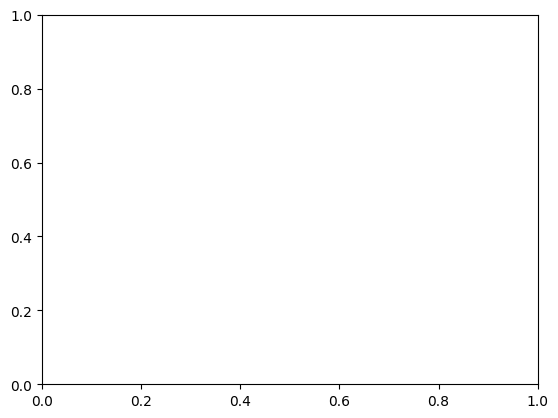

In [72]:
ctv.plot()

In [30]:
ctv.predict_partial_hazard(data_test)

0         0.893641
1         0.980467
2         0.980467
3         0.980467
4         0.980467
            ...   
107088    0.753270
107089    0.753270
107090    0.584268
107091    0.584268
107092    0.643393
Length: 107093, dtype: float64